# Evaluating Gene Correlations - Pancreatic epithelium

In [1]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
Path="/home/mgander/mouse_atlas/data"
ts=['E3.5', 'E4.5', 'E5.25', 'E5.5', 'E6.25', 'E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5a', 'E8.5b', 'E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5']

In [3]:
ct='E11.5:Pancreatic epithelium'
i=16

ts0=ts[i]
ts1=ts[i+1]

In [ ]:
adata=sc.read(f"{Path}/Comb_anndatas/adata_{ts0}_{ts1}.h5ad")
cell_indices=adata[adata.obs['day']==sorted(set(adata.obs['day']))[0]].obs.index

Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].


/home/mgander/.local/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
gT=np.load(f"{Path}/TOME_maps/growth_rates_and_pulls/{ts0}_{ct}_pull.npy", allow_pickle=True)
gM=pd.read_pickle(f"{Path}/moscot_maps/growth_rates_and_pulls2/{ts0}_{ct}_pulls.pkl")
gM=gM.loc[cell_indices].values

# Correlation for curated genes

The following list of genes was obtained by litarture seach when looking for genes that predict deveopment into pancreatic epithelium cells. The key in the dictionary corresponds to the citation (Pubmed ID), and the values correspond to the genes the publication lists.

Be careful, I also listed driver/marker genes if there was only moderate evidence of them being directly involved in these cell transitions, so use this list with caution!!!

In [6]:
# Pancreas

D={}

D['PMID: 17202186']=['Ptf1a', 'Pdx1', 'Neurog3', 'Nkx6-1', 'Nkx2-2', 'Tle3']

D['PMID: 15604203']=['Neurog3', 'Pdx1', 'Slc2a2', 'Iapp', 'Gck', 'Mnx1', 'Hes1', 'Neurod1', 
                     'Pax4', 'Pax6', 'Nkx2-2', 'Nkx6-1', 'Bhlha15']

D['PMID: 15298336']=['Pdx1', 'Nkx2-2', 'Hnf1b', 'Ptf1a', 'Nkx6-1', 'Mnx1', 'Hhex', 'Onecut1', 'Foxa2', 
                     'Hes1', 'Mnx1', 'Ptf1a', 'Nr5a2', 'Neurod1', 'Pax4', 'Pax6', 'Hnf4a', 'Hnf1a']

D['PMID: 25063451']=['Nr5a2', 'Bhlha15', 'Ptf1a', 'Rbpjl']



D['PMID: 17202186, maybe']=['Slc2a2', 'Tle1', 'Tle2', 'Mafa', 'Mafb']

D['PMID: 15298336, maybe']=['Irs2', 'Foxo1', 'Mafa', 'Mafb', 'Gck', 'Iapp', 'Pklr']


D['PMID: 25063451, maybe'] = ['Myc', 'Gata4']

D['Moscot pancreas multiome analysis']=['Btbd17', 'Cadm1', 'Ccdc34', 'Cck', 'Cel', 'Cox7a2l', 'Dctn3', 'Fev', 'Gadd45a', 'Gcg', 'Ghrl', 'Hes6', 'Hhex', 'Ins2', 'Kif11', 'Mki67', 'Nav2', 'Neurod1', 'Neurog3', 'Npepl1', 'Pclo', 'Ppp3ca', 'Ptf1a', 'Rbpjl', 'Reep5', 'Sox9', 'Spp1', 'Sst', 'Tox3', 'Ubl3Arx', 'Yipf4', 'Zwint']

D['PMID: 30254276']=['Reep5', 'Btbd17', 'Gng12', 'Peg10', 'Sst', 'Ngn3', 'Fev', 'Pax4']

D['PMID: 18471525']=['Cadm1']

D['PMID: 31160421']=['Ngn3', 'Sox9', 'Nkx6-1', 'Muc1', 'Cdh1', 'Neurod1', 'Pax4', 'Arx', 'Hes6', 'Fev', 'Cck',
                   'Btbd17', 'Gadd45a', 'Vwa5b2', 'Tox3', 'Dlk1', 'Mdk', 'Btf3', 'Amotl2', 'Cdkn1a', 
                    'Sox4', 'Mfng', 'Btg2', 'Ppp1r14a', 'Mtch1', 'Numbl', 'Hes6', 'Cbfa2t3', 'Rcor2',
                   'Smarcd2', 'Insm1', 'Cbfa2t2', 'Cpa1', 'Myc', 'Notch2', 'Ptf1a', 'Cpa1', 'Cel', 'Rbpjl',
                    'Anxa2']

# These are the genes from PMID: 31160421, Table 2, Upregulated in Ngn3+
# It is not ideal to use these, since Ngn3+ cells appear a little later (~E12), but these drivers/markers
# are likely being started to be expressed already earlier
b0=list(pd.read_csv('/home/mgander/mouse_atlas/data/genes.csv', header=None)[0])

genes=[]
for a in D.values():
    genes=[*genes, *a]
genes=[*genes, *b0]

# Eliminate duplicates
genes=[a for a in set(genes)]

In [8]:
adata=sc.read(f"{Path}/Comb_anndatas/scVI_anndatas/scvi_adata_{ts0}.h5ad")
adata.var.index=list(adata.var['gene_names'])

In [9]:
hvgs=list(adata.var[adata.var['highly_variable']]['gene_names'])
genes_selected=[]
for gene in genes:
    if gene in hvgs:
        genes_selected.append(gene)
len(genes_selected)

106

In [19]:
subset=True

DF=pd.DataFrame({})

for gene in genes_selected:
    loc=adata.var.index.get_loc(gene)
    exp=adata.layers['scvi_normalized'][:,loc]
    #exp=adataS.X[:,loc]
    #exp=np.array(exp.todense()).T[0]

    if subset==True:
        wh=np.where(adata.obs['cell_state']=='E10.5:Gut and lung epithelium')[0]
        exp=exp[wh]
        gT2=gT[wh]
        gM2=gM[wh]
    else:
        gT2=gT.copy()
        gM2=gM.copy()


    (cor, p)=scipy.stats.spearmanr(exp, gT2)
    dfT=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'TOME', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
    (cor, p)=scipy.stats.spearmanr(exp, gM2)
    dfM=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'moscot', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
    DF=pd.concat([DF, dfM,dfT])
DF['Abs. Correlation']=abs(DF['Correlation'])
DF.index=np.arange(len(DF))

<Axes: xlabel='Abs. Correlation', ylabel='Timepoint'>

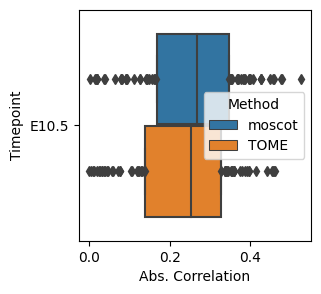

In [20]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
sns.boxplot(data=DF, x="Abs. Correlation", y="Timepoint", hue='Method', showfliers=True,
               showmeans=False,  whis=[100,0], ax=ax)

In [21]:
DF.to_pickle(f'{Path}/Validation_output/{ts0}_PE.npy')